In [1]:
%load_ext autoreload
#import race
#import math
#import random

#import gym
import numpy as np

#import torch
#import torch.nn as nn
#import torch.optim as optim
#import torch.nn.functional as F
#from torch.distributions import Normal

#from IPython.display import clear_output
import matplotlib.pyplot as plt
import optuna
#import importlib
import CurvyRaceEnv
#importlib.reload(CurvyRaceEnv)
%matplotlib inline
%reload_ext autoreload

In [2]:
from stable_baselines3.common.env_checker import check_env
#import CurvyRaceEnv
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [3]:
from gymnasium.envs.registration import register

register(
     id="CurvyRaceEnv-v0",
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

In [4]:
from typing import Any
from typing import Dict

import gymnasium
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

import torch
import torch.nn as nn
import time
N_TRIALS = 10000
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = 20000
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CurvyRaceEnv-v0"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}

In [5]:
def evaluate_model(model, env, num_episodes=100):  
    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [8]:
from stable_baselines3 import A2C, PPO, TD3, DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

def objective(trial: optuna.Trial) -> float:   
    hyperparams = {
        'learning_starts': trial.suggest_int('learning_starts', 50,400),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'gamma': trial.suggest_float('gamma', 0.9, 0.999),
        'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True),
        'batch_size': trial.suggest_int('batch_size', 16,1024),
        
    }
    # Define the environment
    env = gymnasium.make('CurvyRaceEnv-v0')  
    

    # Create and train the DDPG model
    model = SAC('MlpPolicy', env, learning_starts=hyperparams['learning_starts'] ,learning_rate=hyperparams['learning_rate'],
                 gamma=hyperparams['gamma'], tau=hyperparams['tau'], batch_size=hyperparams['batch_size'],
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
    
    # Train the model
    model.learn(total_timesteps=10000)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)

    return mean_reward

In [ ]:
study = optuna.create_study(study_name="SAC", storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

eval_env = gymnasium.make("CurvyRaceEnv-v0")
eval_callback = EvalCallback(eval_env, best_model_save_path='model/best_model',
                            log_path='logs/best_model_log', eval_freq=1000,
                            deterministic=True, render=False,
                            callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=3500, verbose=1))

In [46]:
def learn_model(env, model, hyperparameters, timesteps, monitor_dir, model_dir):
    monitor = Monitor(env, monitor_dir)

    match model:
        case "DDPG":
            model = DDPG("MlpPolicy", monitor, **hyperparameters)
        case "TD3":
            model = TD3(**hyperparameters)

        case "SAC":
            model = SAC(**hyperparameters)

        case "A2C":
            model = A2C(**hyperparameters)

        case "PPO":
            model = PPO(**hyperparameters)        
        case _:
            print("Unsupported model. Try DDPG, TD3, SAC, A2C or PPO instead")
            return
    
    model.learn(total_timesteps=timesteps)
    model.save(model_dir)
    _, _ = env.reset()
    del model


In [55]:
import race
test = race.CurvyRace()
len(test.get_gates())


16

In [47]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DDPG, TD3, SAC, A2C,PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


env = gymnasium.make("CurvyRaceEnv-v0")


learn_model(env, "DDPG", {"action_noise":NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)),  "learning_rate":0.004859847958257243,"tau":0.06431401009446525,  "gamma": 0.9903705891833702, "buffer_size":2000000}, 10000, "logs/ddpg", "models/ddpg")




#env = Monitor(env, "logs/sac")
#model_sac = SAC("MlpPolicy", env,action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)), batch_size=826, learning_rate=0.0016540625796751618,tau=0.015202248089828913,  gamma = 0.9592430447956614, buffer_size=2000000)
#model_sac.learn(total_timesteps=10000)
#model_sac.save("models/model_sac")
#_, _ = env.reset()
#del model_sac

#env = Monitor(env, "logs/a2c")
#model_a2c = A2C("MlpPolicy", env,  learning_rate=0.004859847958257243,  gamma = 0.9703705891833702)
#model_a2c.learn(total_timesteps=150000)
#model_a2c.save("models/model_a2c")
#_, _ = env.reset()
#del model_a2c

#env = Monitor(env, "logs/ppo")
#model_ppo = PPO("MlpPolicy", env,  learning_rate=0.004859847958257243,  gamma = 0.9703705891833702)
#model_ppo.learn(total_timesteps=150000)
#model_ppo.save("models/model_ppo")
#_, _ = env.reset()
#del model_ppo

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


In [48]:
env.close()

In [49]:
def run_env(env, model):
    obs, info = env.reset()
    done = False
    reward_list = []
    observation_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info, _ = env.step(action)
        print(f"obs: {obs}")
        observation_list.append(obs)
        reward_list.append(rewards)
    env.render()
    return reward_list

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards per episode.
    """
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


In [51]:
import pandas as pd
def load_log(path):
    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

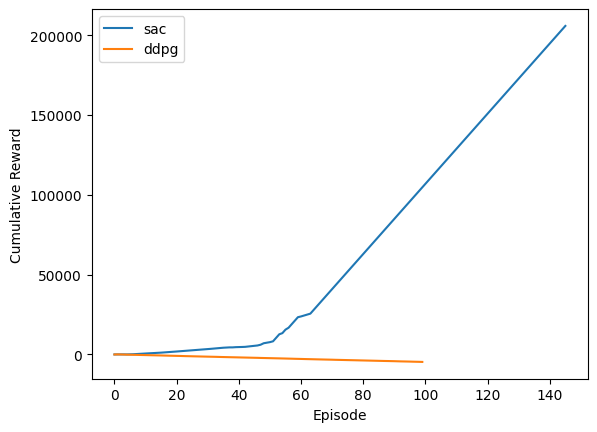

In [52]:
from stable_baselines3 import DDPG,SAC, TD3, A2C, PPO

sac = SAC.load("models/model_sac.zip")
#td3 = TD3.load("models/model_td3.zip")
ddpg = DDPG.load("models/ddpg.zip")
#ppo = PPO.load("models/model_ppo.zip")
#a2c = A2C.load("models/model_a2c.zip")
test = gymnasium.make("CurvyRaceEnv-v0")

rewards = {}
#rewards["td3"] = load_log("logs/td3.monitor.csv")
rewards["sac"] = load_log("logs/sac.monitor.csv")
rewards["ddpg"] = load_log("logs/ddpg.monitor.csv")

#rewards["a2c"] = load_log("logs/a2c.monitor.csv")
#rewards["ppo"] = load_log("logs/ppo.monitor.csv")



plot_cumulative_rewards(rewards)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


obs: [ 0.8444694   0.00756186  0.42185712 -0.4284011   1.1555552 ]
obs: [ 1.5743335   0.33512625  0.82185715 -1.4888047   0.5417578 ]
obs: [ 2.1190233  0.9210555  1.2218571 -1.6772056  2.0943773]
obs: [ 2.3925443  1.6728442  1.6218572 -2.4271863  2.3199832]
obs: [ 2.3517132  2.4718015  2.021857  -3.0045335  2.9709682]
obs: [2.002977  3.1917896 2.421857  2.8496165 3.7650528]
obs: [1.4013928 3.7191384 2.8218572 2.500393  4.537042 ]
obs: [0.641938  3.9705908 3.221857  2.1925437 5.2002087]
obs: [-0.15548646  3.9064481   3.6218572   1.9068109   5.7033677 ]
obs: [-0.8649847  3.536837   4.0218573  1.6327112  6.014756 ]
obs: [-1.3745425  2.9201112  4.4218574  1.3636259  6.1165967]
obs: [-1.603712   2.153638   4.821857   1.0944086  6.003311 ]
obs: [-1.5163122   1.3584265   5.221857    0.81987613  5.681111  ]
obs: [-1.1261418  0.6600232  5.621857   0.5332764  5.1684585]
obs: [-0.49480006  0.16869076  6.0218573   0.22381558  4.4979644 ]
obs: [ 0.27803808 -0.03800034  6.4218574  -0.12846242  3.722

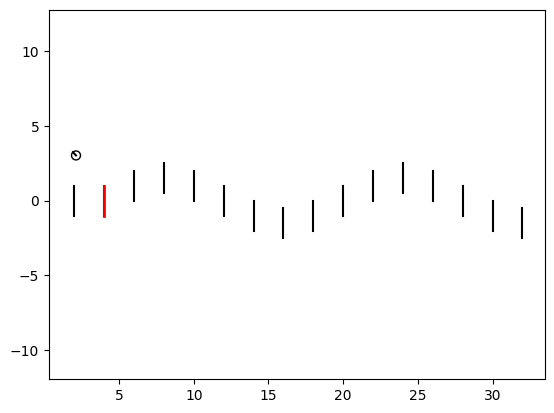

[0.13166088528542189,
 0.7057053376761602,
 10.689004424626793,
 1.0478800765978205,
 1.2900547408310663,
 -1.6937405579333038,
 -1.5742709047697452,
 -1.4677154015047416,
 -1.3607888351351192,
 -1.2459810452701734,
 -1.118712723514141,
 -0.9760122767049975,
 -0.8157317114001403,
 -0.6358137744275604,
 -0.4331909658762841,
 -0.2016370703100981,
 0.0723965612834469,
 0.41150215741120344,
 0.8031289802872175,
 1.1306434920988349,
 1.3423836665570033,
 -1.6563495320303667,
 -1.542565164680116,
 -1.4369375380448794,
 -1.3283200450042574,
 -1.2102571567030607,
 -1.0787396597974155,
 -0.931107886472186,
 -0.7653235675710319,
 -0.5791780703665167,
 -0.3689757576155893,
 -0.12688376272632954,
 0.16371044616981162,
 0.5239325320386243,
 0.9109921916482118,
 1.2028558011365564,
 -1.7525993471524874,
 -1.6213131694807723,
 -1.5114963022120564,
 -1.4058763904616378,
 -1.2950306486115957,
 -1.1733772848116597,
 -1.0373881929757935,
 -0.8846560583057318,
 -0.7131875307150611,
 -0.5205153700195646,
 

In [35]:
run_env(test, ddpg)

In [21]:
evaluate_model(a2c, test)

-9.641425656355883